#### The idea behind this project is to create clusters of movies with similar storyline and use those clusters in recommender systems. It has been observed in the past that people have a preference to story types, just like genres, as some of them may like police-criminal showdowns and others may like love stories. This project will help identifying similar movies and if a user has liked movies from a cluster, other movies from the same cluster that have not been watched by the user can be targetted to the user as recommendations. 

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import numpy as np
import hdbscan
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from nltk.corpus import stopwords
stop = stopwords.words('english')
from collections import Counter
from wordcloud import WordCloud
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import itertools
import pydot
import graphviz

In [2]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zezé Motta, Celso Frateschi",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi & Fantasy","In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor."
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, Azalia Ortiz, Octavio Michel, Carmen Beato",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies","After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive."
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence Koh, Tommy Kuan, Josh Lai, Mark Lee, Susan Leong, Benjamin Lim",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly, Christopher Plummer, Crispin Glover, Martin Landau, Fred Tatasciore, Alan Oppenheimer, Tom Kane",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi & Fantasy","In a postapocalyptic world, rag-doll robots hide in fear from dangerous machines out to exterminate them, until a brave newcomer joins the group."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aaron Yoo, Liza Lapira, Jacob Pitts, Laurence Fishburne, Jack McGee, Josh Gad, Sam Golzari, Helen Carey, Jack Gilpin",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-counting experts with the intent of swindling millions out of Las Vegas casinos by playing blackjack.


In [3]:
df.shape

(7787, 12)

# Identifying important features

Since the application of this project is aimed at building recommender systems, the features _'rating'_ and _'listed_in'_ have been taken into consideration for the the following purposes:

- __Rating__: It is important to provide appropriate recommendations to public as there could be a movie of an animated cop & criminal chase that is aimed at children audience and another movie with a similar plot and have strong language that is not appropriate for them. Hence, by including this feature for modeling, it may separate such similarities in the dataset.

- __Genre__: The genre of a movie can be captured with the listed_in feature of the dataset. It also helps in grouping similar movies together as not all movies that have a cop/criminal/detective plot are Crime/Thriller/Mystery but can also be a Comedy/Romantic/Drama. Hence, this feature helps in separting such movies.

- __Description__: The description feature gives us a rough idea of what the movie is about. People who do not have a movie in mind often look at these descriptions to decide if they are interested in watching the movie or not. Hence, this is the most important feature in the dataset and it helps in identifying movies that have similar plots or storylines.

In [4]:
df.rating.unique()

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y', nan,
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

In [5]:
df = pd.get_dummies(df, prefix=['rating'], columns=['rating'])    # One hot encode the 'rating' feature
listed_in = df['listed_in']
all_movies_genres_list = []                                       # this list will contain sublists of genres of movies by index
for i in range(df.shape[0]):
    movie_genres_list = listed_in[i].split(', ')
    all_movies_genres_list.append(movie_genres_list)              # append a list of genres for each movie
df['list_of_genres'] = np.array(all_movies_genres_list)
all_genres = [item for sublist in all_movies_genres_list for item in sublist] # list of all genres

In [6]:
list(set(all_genres))                                             # list of all the genres in the dataset

['Stand-Up Comedy & Talk Shows',
 'Horror Movies',
 'Children & Family Movies',
 'TV Sci-Fi & Fantasy',
 'TV Horror',
 'Classic & Cult TV',
 'Movies',
 'Classic Movies',
 'Dramas',
 'International TV Shows',
 'Comedies',
 'Science & Nature TV',
 'TV Thrillers',
 'Stand-Up Comedy',
 'Sports Movies',
 'Romantic TV Shows',
 'LGBTQ Movies',
 "Kids' TV",
 'TV Comedies',
 'Anime Series',
 'Thrillers',
 'Faith & Spirituality',
 'Docuseries',
 'Spanish-Language TV Shows',
 'British TV Shows',
 'Anime Features',
 'International Movies',
 'Romantic Movies',
 'Cult Movies',
 'Korean TV Shows',
 'Crime TV Shows',
 'Music & Musicals',
 'Sci-Fi & Fantasy',
 'TV Action & Adventure',
 'Independent Movies',
 'TV Shows',
 'Documentaries',
 'Action & Adventure',
 'Reality TV',
 'TV Mysteries',
 'Teen TV Shows',
 'TV Dramas']

In [7]:
                                                 # One hot encode the 'listed_in' feature
for genre in list(set(all_genres)):
    df['listed_in_'+genre] = 0                   # create features of all genres and initialize the values to 0
for index, row in df.iterrows():
    for genre in row['list_of_genres']:
        df.at[index,'listed_in_'+genre] = 1      # set value 1 if a movie is of a particular genre

In [8]:
df.columns                                       # all columns currently in the data frame

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'duration', 'listed_in', 'description', 'rating_G',
       'rating_NC-17', 'rating_NR', 'rating_PG', 'rating_PG-13', 'rating_R',
       'rating_TV-14', 'rating_TV-G', 'rating_TV-MA', 'rating_TV-PG',
       'rating_TV-Y', 'rating_TV-Y7', 'rating_TV-Y7-FV', 'rating_UR',
       'list_of_genres', 'listed_in_Stand-Up Comedy & Talk Shows',
       'listed_in_Horror Movies', 'listed_in_Children & Family Movies',
       'listed_in_TV Sci-Fi & Fantasy', 'listed_in_TV Horror',
       'listed_in_Classic & Cult TV', 'listed_in_Movies',
       'listed_in_Classic Movies', 'listed_in_Dramas',
       'listed_in_International TV Shows', 'listed_in_Comedies',
       'listed_in_Science & Nature TV', 'listed_in_TV Thrillers',
       'listed_in_Stand-Up Comedy', 'listed_in_Sports Movies',
       'listed_in_Romantic TV Shows', 'listed_in_LGBTQ Movies',
       'listed_in_Kids' TV', 'listed_in_TV Comedies', '

# Sentence Embeddings

Now that the features _Genre_ and _Rating_ are ready, we need the _'description'_ feature to understand what the movie is about and to get to know the plot of the movie. Since this is a string type feature we have to create sentence embeddings for the model to understand what the movie is about. Sentence embeddings are numerical ways of representing a sentence. Here, I have used BERT sentence embeddings to get numerical representations of all movie descriptions.

In [9]:
descriptions = df['description'].values.tolist()                               # a list of descriptions of all movies by index
sentence_transformer = SentenceTransformer('paraphrase-distilroberta-base-v1') # initialize BERT sentence embeddings transformer
embeddings = sentence_transformer.encode(descriptions)                         # get sentence embeddings of all descriptions
embeddings.shape

(7787, 768)

# Dimensionality Reduction

Since each sentence has 768 features, it would be computatuonally expensive to build a model with so many features. Also, lot of features to describe the storyline/plot would give more weightage to the plot and undermine the importance of other features like Genre and Rating. So, by using Uniform Manifold Approximation and Projection (UMAP), I have reduced the number of features from 768 to 200.

In [10]:
reduced_dims_embeddings = umap.UMAP(n_neighbors=30, min_dist=0.3, n_components=200, metric='cosine').fit_transform(embeddings)
reduced_dims_embeddings.shape

(7787, 200)

# Build input dataset

Concatenate all the input features to get the input dataset to generate clusters.  

In [11]:
genre_rating_info = df[['rating_G',
       'rating_NC-17', 'rating_NR', 'rating_PG', 'rating_PG-13', 'rating_R',
       'rating_TV-14', 'rating_TV-G', 'rating_TV-MA', 'rating_TV-PG',
       'rating_TV-Y', 'rating_TV-Y7', 'rating_TV-Y7-FV', 'rating_UR',
       'listed_in_Sports Movies', 'listed_in_TV Dramas',
       'listed_in_TV Action & Adventure', 'listed_in_Sci-Fi & Fantasy',
       "listed_in_Kids' TV", 'listed_in_Faith & Spirituality',
       'listed_in_TV Sci-Fi & Fantasy', 'listed_in_Movies',
       'listed_in_Crime TV Shows', 'listed_in_TV Thrillers',
       'listed_in_TV Shows', 'listed_in_TV Mysteries',
       'listed_in_Spanish-Language TV Shows', 'listed_in_Anime Features',
       'listed_in_Classic Movies', 'listed_in_Science & Nature TV',
       'listed_in_TV Horror', 'listed_in_Comedies', 'listed_in_Teen TV Shows',
       'listed_in_Independent Movies', 'listed_in_Docuseries',
       'listed_in_Cult Movies', 'listed_in_Horror Movies',
       'listed_in_LGBTQ Movies', 'listed_in_Romantic Movies',
       'listed_in_Classic & Cult TV', 'listed_in_Documentaries',
       'listed_in_Music & Musicals', 'listed_in_International TV Shows',
       'listed_in_Dramas', 'listed_in_Thrillers', 'listed_in_Reality TV',
       'listed_in_Children & Family Movies',
       'listed_in_Stand-Up Comedy & Talk Shows', 'listed_in_Romantic TV Shows',
       'listed_in_Action & Adventure', 'listed_in_Stand-Up Comedy',
       'listed_in_International Movies', 'listed_in_Korean TV Shows',
       'listed_in_TV Comedies', 'listed_in_Anime Series',
       'listed_in_British TV Shows']].to_numpy()
genre_rating_info.shape                                                           # input features of genre and rating

(7787, 56)

In [12]:
inputs = np.concatenate((reduced_dims_embeddings, genre_rating_info), axis=1)     # concatenate genre and rating features with reduced dimensions of sentence embeddings 
inputs.shape

(7787, 256)

# Clustering

#### HDBSCAN - Hierarchical Density Based Clustering algorithm. 

This would detect movies that are very similar to each other in the multi-dimensional vector space and group them into a single cluster. It would leave out the movies that are very different without assigning a cluster to them. 

In [13]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30)
hd = clusterer.fit_predict(inputs)
unique, counts = np.unique(hd, return_counts=True)
dict(zip(unique, counts))                              # this gives us the number of movies in every cluster

{-1: 6046,
 0: 40,
 1: 39,
 2: 91,
 3: 124,
 4: 50,
 5: 39,
 6: 48,
 7: 70,
 8: 35,
 9: 100,
 10: 55,
 11: 128,
 12: 267,
 13: 52,
 14: 304,
 15: 299}

__Observation:__ It did a good job of grouping similar movies but did not assign any cluster to majority of the dataset (6033 movies). This would not help in the recommendation process as we need a cluster for every movie - even if the similarity score is less. The ones with lesser similarity score can be recommended in the end after the user has watched the ones with high similarity. Hence, HDBSCAN would not serve the purpose of our clustering.

#### K-means Hard Clustering

K-means is a clustering algorithm that finds similarities in every dimension in the input data and groups data points into clusters. This would help solve our purpose as it would also give equal weightage to Genre and Rating. The number of clusters has to be determined here and for that, I have experimented with a range between 1 to 30 and would determine this number by using the elbow method by considering distortion (square of distance from centroids) as the evaluation metric.

In [14]:
distortions = []
mapping = {}

for k in range(1,30):
    kmeanModel = KMeans(n_clusters=k).fit(inputs)
    kmeanModel.fit(inputs)
    distortions.append(sum(np.min(cdist(inputs, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / inputs.shape[0])
    mapping[k] = sum(np.min(cdist(inputs, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / inputs.shape[0]

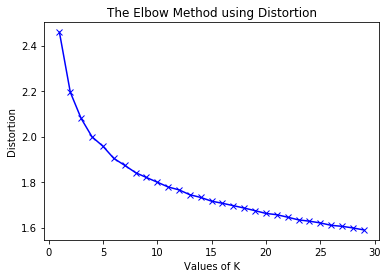

In [15]:
plt.plot(range(1,30), distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [16]:
for key, val in mapping.items():
    print(f'{key} : {val}')

1 : 2.458844883023088
2 : 2.195240117289881
3 : 2.0796338920207464
4 : 1.998897494617498
5 : 1.9578344666775596
6 : 1.9042574901623606
7 : 1.8737823456481304
8 : 1.8416402837239436
9 : 1.8201966666002982
10 : 1.7996437440093827
11 : 1.7784368058028381
12 : 1.7657916148982802
13 : 1.7442962965941067
14 : 1.7324345888430335
15 : 1.7159745973403548
16 : 1.7067003516117623
17 : 1.6962938883366427
18 : 1.6857214097999358
19 : 1.6741901857618418
20 : 1.6621423064799663
21 : 1.656478543898463
22 : 1.6455442302431194
23 : 1.6337314812247472
24 : 1.6279878842684348
25 : 1.6204155269249891
26 : 1.609793494292176
27 : 1.6053961908510843
28 : 1.598299133909887
29 : 1.5896124185650664


__Observation:__ The K-means clustering algorithm has built meaningful clusters for the dataset and the right number of clusters, I suppose is 10 (from the graph and the change in distortion values) as the values decrease by 0.7 in the first 10 incrementations and only by 0.15 in the next 20 incrementations. Hence, I see that 10 is a good number for the number of clusters to be generated.

In [17]:
kmeanModel = KMeans(n_clusters=10).fit(inputs)
kmeanModel.fit(inputs)
unique, counts = np.unique(kmeanModel.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 532,
 1: 531,
 2: 477,
 3: 883,
 4: 1018,
 5: 932,
 6: 1086,
 7: 722,
 8: 439,
 9: 1167}

__Observation:__ The clusters are all well generated with good number of movies in every cluster. Now let's look at why these clusters are grouped so. What are the similarities in every cluster?

In [18]:
df['cluster'] = kmeanModel.labels_                      #assign cluster number as a feature to every data point in the dataframe

In [19]:
cluster_words = {}
for i in df['cluster'].unique():
    cluster_words['cluster'+str(i)] = []                # cluster_words is a dictionary with keys as clusters and values as a list of all words in the decription of movies in that cluster

whitelist = set('abcdefghijklmnopqrstuvwxyz 0123456789') # a set of all characters to be counted as a word (eliminating punctuations and special characters)

for index, row in df.iterrows():
    cluster = 'cluster'+str(row['cluster'])                                 # get the cluster of a movie
    description = row['description'].lower()                                # get the description of the movie in lower case
    description = ''.join(filter(whitelist.__contains__, description))      # eliminate special characters 
    words = description.split()
    for word in words:
        cluster_words[cluster].append(word)                                 # append to custer_words dictionary
        
for key in cluster_words:
    cluster_words[key] = [word for word in cluster_words[key] if word not in stop]    #eliminate all stop words from all values of the cluster_words dictionary

# Visualization: Word Cloud of movie descriptions from every cluster

Let's see if the movies that are grouped together have any similarity in terms of storyline / descriptions in every cluster

In [20]:
def plot_wordcloud(cluster):
    unique_string=(" ").join(cluster_words[cluster])
    wordcloud = WordCloud(width = 500, height = 250).generate(unique_string)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

Cluster  0


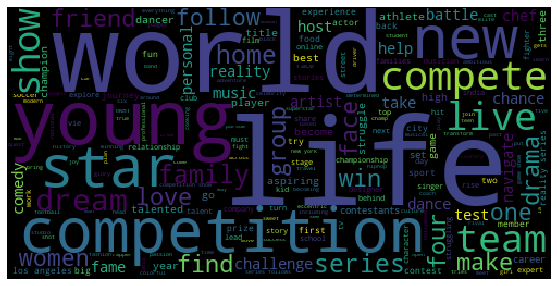

Cluster  1


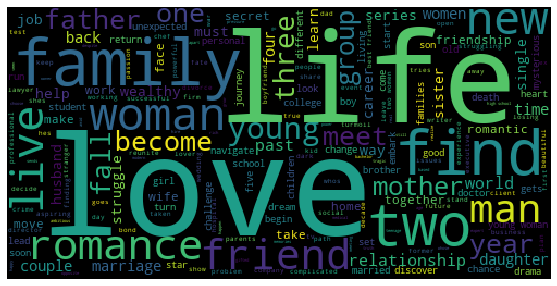

Cluster  2


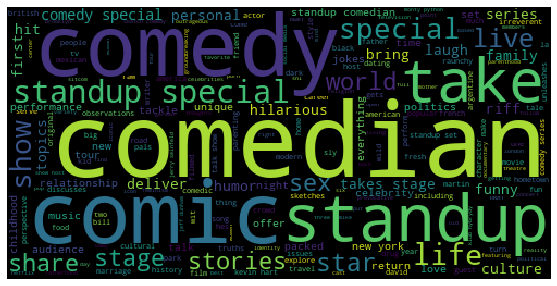

Cluster  3


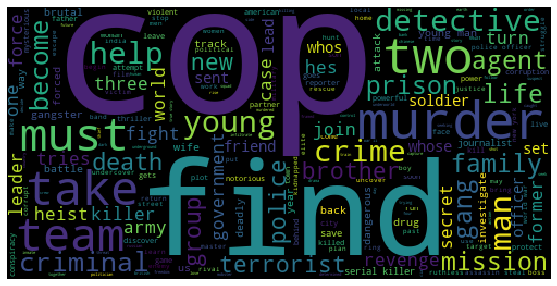

Cluster  4


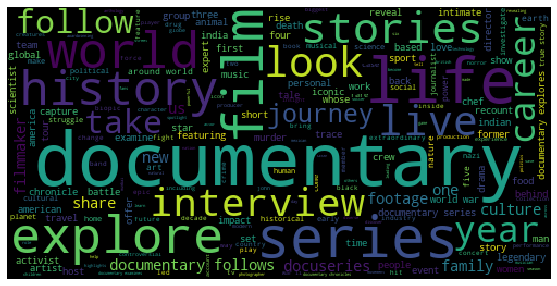

Cluster  5


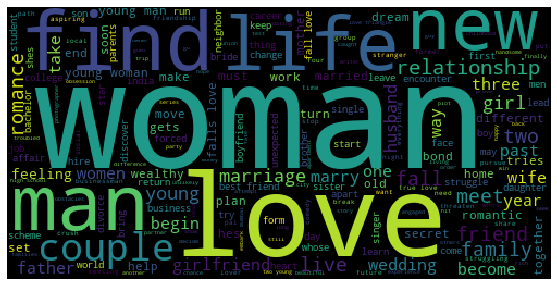

Cluster  6


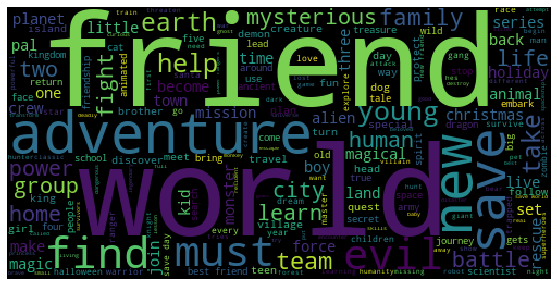

Cluster  7


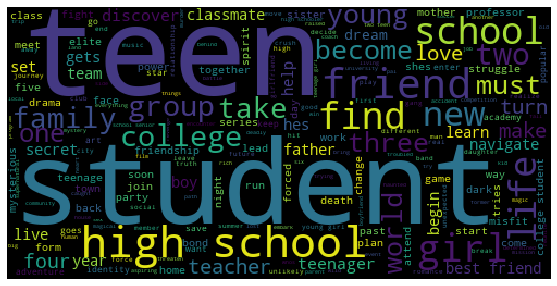

Cluster  8


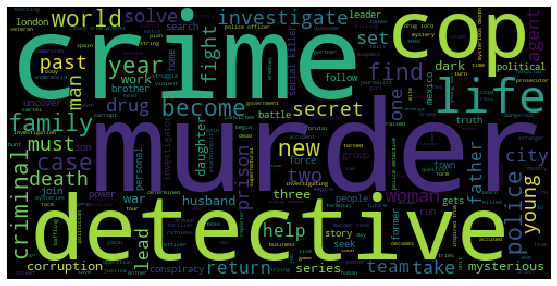

Cluster  9


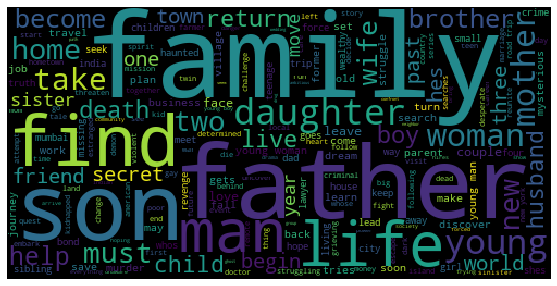

In [21]:
for i in range(0,10):
    print('Cluster ',i)
    plot_wordcloud('cluster'+str(i))

__Observation:__ We see that movies are clustered meaningfully as every cluster has a particular storytype that one can identify. The observations are as follows:

- Cluster 0: Romance, Love, Life, Marry, Couple ---------------------> ROMANTIC STORIES
- Cluster 1: Documentary, Interview, True Story, History, Biopic ----> REAL LIFE EVENTS
- Cluster 2: Family, Wife, Father, Son, Daughter, Brother -----------> FAMILY STORIES
- Cluster 3: Prison, Heist, Cop, Crime, Revenge ---------------------> POLICE STORIES
- Cluster 4: Relationship, Together, Husband, Wedding, Girlfriend ---> BONDING STORIES
- Cluster 5: Teen, Student, High School, Friend, Young --------------> COLLEGE LIFE STORIES
- Cluster 6: Comedy, Comic, Standup, Comedian, Humor ----------------> COMEDY STORIES
- Cluster 7: New, World, Adventure, Planet, Discover, Mysterious ----> ADVENTUROUS STORIES
- Cluster 8: Murder, Mystery, Detective, Death, Investigate ---------> CRIME STORIES
- Cluster 9: World, travel, Explore, Live, Host, Food ---------------> TRAVEL STORIES


# Classification 

A classification model that tries to predict the cluster of every movie. The input features are the same as that of the clustering model. The sequence and context of words used in the descriptions are captured by the BERT sentence embeddings. A deep learning model with a simple architecture has been trained by  80-20 split and 5 - fold cross validation.

In [22]:
labels = df['cluster'].to_numpy()
data = np.column_stack((inputs, labels))
data.shape

(7787, 257)

In [37]:
np.random.shuffle(data)

In [38]:
inputs = data[:,:-1]
labels = data[:,-1:]
inputs.shape, labels.shape

((7787, 256), (7787, 1))

#### Train - Test split 80-20:

In [39]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, test_size=0.2)
train_labels = train_labels.reshape((train_labels.shape[0],))
test_labels = test_labels.reshape((test_labels.shape[0],))
train_inputs.shape, test_inputs.shape, train_labels.shape, test_labels.shape

((6229, 256), (1558, 256), (6229,), (1558,))

In [40]:
tfmodel = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(256,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Flatten(input_shape=(128,)),
  tf.keras.layers.Dense(64, activation='relu'),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation = 'softmax')
])

In [41]:
tfmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
tfmodel.fit(train_inputs, train_labels, epochs=50)

Train on 6229 samples
Epoch 1/50
6229/6229 [==============================] - 1s 116us/sample - loss: 2.2118 - accuracy: 0.2126
Epoch 2/50
6229/6229 [==============================] - 0s 69us/sample - loss: 1.6433 - accuracy: 0.4564
Epoch 3/50
6229/6229 [==============================] - 0s 67us/sample - loss: 1.1875 - accuracy: 0.6054
Epoch 4/50
6229/6229 [==============================] - 0s 69us/sample - loss: 0.9858 - accuracy: 0.6571
Epoch 5/50
6229/6229 [==============================] - 0s 66us/sample - loss: 0.8549 - accuracy: 0.6881
Epoch 6/50
6229/6229 [==============================] - 0s 69us/sample - loss: 0.7505 - accuracy: 0.7301
Epoch 7/50
6229/6229 [==============================] - 0s 70us/sample - loss: 0.6642 - accuracy: 0.7542
Epoch 8/50
6229/6229 [==============================] - 0s 69us/sample - loss: 0.6253 - accuracy: 0.7675
Epoch 9/50
6229/6229 [==============================] - 0s 68us/sample - loss: 0.5329 - accuracy: 0.8049
Epoch 10/50
6229/6229 [=========

In [43]:
test_predictions = tfmodel.predict(test_inputs)
test_predictions = np.argmax(test_predictions,axis = 1)
print('Accuracy: ',np.sum(test_labels==test_predictions)/test_predictions.shape[0]*100)

Accuracy:  91.27086007702182


In [44]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('\nPredicted label\n\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

__Result:__ Confusion Matrix for the classification model

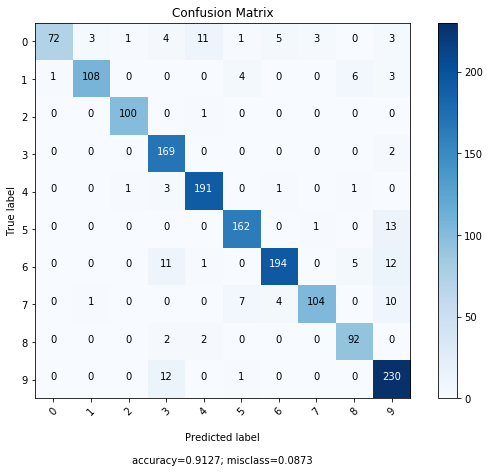

In [45]:
cm = confusion_matrix(test_labels, test_predictions)
plot_confusion_matrix(cm, [0,1,2,3,4,5,6,7,8,9], title='Confusion Matrix', cmap=None, normalize=False)

In [46]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [47]:
precision, recall

(array([0.98630137, 0.96428571, 0.98039216, 0.84079602, 0.92718447,
        0.92571429, 0.95098039, 0.96296296, 0.88461538, 0.84249084]),
 array([0.69902913, 0.8852459 , 0.99009901, 0.98830409, 0.96954315,
        0.92045455, 0.86995516, 0.82539683, 0.95833333, 0.94650206]))

In [48]:
for i in range(len(precision)):
    print('Precision of class '+str(i)+' = ',precision[i])
    print('Recall of class '+str(i)+' = ',recall[i],'\n')

Precision of class 0 =  0.9863013698630136
Recall of class 0 =  0.6990291262135923 

Precision of class 1 =  0.9642857142857143
Recall of class 1 =  0.8852459016393442 

Precision of class 2 =  0.9803921568627451
Recall of class 2 =  0.9900990099009901 

Precision of class 3 =  0.8407960199004975
Recall of class 3 =  0.9883040935672515 

Precision of class 4 =  0.9271844660194175
Recall of class 4 =  0.9695431472081218 

Precision of class 5 =  0.9257142857142857
Recall of class 5 =  0.9204545454545454 

Precision of class 6 =  0.9509803921568627
Recall of class 6 =  0.8699551569506726 

Precision of class 7 =  0.9629629629629629
Recall of class 7 =  0.8253968253968254 

Precision of class 8 =  0.8846153846153846
Recall of class 8 =  0.9583333333333334 

Precision of class 9 =  0.8424908424908425
Recall of class 9 =  0.9465020576131687 



#### 5 fold cross validation:

In [49]:
kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(inputs, labels):
    tfmodel = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(256,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Flatten(input_shape=(128,)),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = 'softmax')
    ])

    tfmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = tfmodel.fit(inputs[train], labels[train], epochs=50)
    
    scores = tfmodel.evaluate(inputs[test], labels[test], verbose=0)
    print(f'Score for fold {fold_no}: {tfmodel.metrics_names[0]} of {scores[0]}; {tfmodel.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Train on 6229 samples
Epoch 1/50
6229/6229 [==============================] - 1s 119us/sample - loss: 2.1628 - accuracy: 0.2180
Epoch 2/50
6229/6229 [==============================] - 0s 71us/sample - loss: 1.6121 - accuracy: 0.4526
Epoch 3/50
6229/6229 [==============================] - 0s 71us/sample - loss: 1.1368 - accuracy: 0.6054
Epoch 4/50
6229/6229 [==============================] - 0s 72us/sample - loss: 0.8638 - accuracy: 0.6959
Epoch 5/50
6229/6229 [==============================] - 0s 70us/sample - loss: 0.7768 - accuracy: 0.7184
Epoch 6/50
6229/6229 [==============================] - 0s 71us/sample - loss: 0.6681 - accuracy: 0.7528
Epoch 7/50
6229/6229 [==============================] - 0s 72us/sample - loss: 0.5740 - accuracy: 0.7894s - loss: 0.5837 - accu
Epoch 8/50
6229/6229 [==============================] - 0s 75us/sample - loss: 0.5867 - accuracy: 0.7786
Epoch 9/50
6229/6

6229/6229 [==============================] - 0s 65us/sample - loss: 0.4001 - accuracy: 0.8420
Epoch 26/50
6229/6229 [==============================] - 0s 75us/sample - loss: 0.2848 - accuracy: 0.8876
Epoch 27/50
6229/6229 [==============================] - 1s 81us/sample - loss: 0.3548 - accuracy: 0.8645
Epoch 28/50
6229/6229 [==============================] - 0s 70us/sample - loss: 0.2825 - accuracy: 0.8902
Epoch 29/50
6229/6229 [==============================] - 0s 65us/sample - loss: 0.3088 - accuracy: 0.8806
Epoch 30/50
6229/6229 [==============================] - 0s 65us/sample - loss: 0.2862 - accuracy: 0.8889
Epoch 31/50
6229/6229 [==============================] - 0s 75us/sample - loss: 0.3895 - accuracy: 0.8435
Epoch 32/50
6229/6229 [==============================] - 0s 73us/sample - loss: 0.2736 - accuracy: 0.8892
Epoch 33/50
6229/6229 [==============================] - 0s 77us/sample - loss: 0.2936 - accuracy: 0.8783
Epoch 34/50
6229/6229 [==============================] - 0

6230/6230 [==============================] - 0s 69us/sample - loss: 0.2344 - accuracy: 0.9058
Score for fold 3: loss of 0.32666651993587986; accuracy of 85.16377806663513%
------------------------------------------------------------------------
Training for fold 4 ...
Train on 6230 samples
Epoch 1/50
6230/6230 [==============================] - 1s 167us/sample - loss: 2.2367 - accuracy: 0.2098
Epoch 2/50
6230/6230 [==============================] - 1s 81us/sample - loss: 1.8306 - accuracy: 0.3796
Epoch 3/50
6230/6230 [==============================] - 0s 73us/sample - loss: 1.3439 - accuracy: 0.5608
Epoch 4/50
6230/6230 [==============================] - 0s 72us/sample - loss: 1.0705 - accuracy: 0.6291
Epoch 5/50
6230/6230 [==============================] - 0s 71us/sample - loss: 0.9154 - accuracy: 0.6746
Epoch 6/50
6230/6230 [==============================] - 0s 71us/sample - loss: 0.8204 - accuracy: 0.7021
Epoch 7/50
6230/6230 [==============================] - 0s 73us/sample - loss:

6230/6230 [==============================] - 0s 77us/sample - loss: 0.3022 - accuracy: 0.8791
Epoch 24/50
6230/6230 [==============================] - 0s 71us/sample - loss: 0.3332 - accuracy: 0.8714
Epoch 25/50
6230/6230 [==============================] - 0s 72us/sample - loss: 0.2794 - accuracy: 0.8931
Epoch 26/50
6230/6230 [==============================] - 0s 75us/sample - loss: 0.3151 - accuracy: 0.8734
Epoch 27/50
6230/6230 [==============================] - 0s 71us/sample - loss: 0.3265 - accuracy: 0.8716
Epoch 28/50
6230/6230 [==============================] - 0s 72us/sample - loss: 0.3869 - accuracy: 0.8538
Epoch 29/50
6230/6230 [==============================] - 0s 72us/sample - loss: 0.2602 - accuracy: 0.8942
Epoch 30/50
6230/6230 [==============================] - 0s 73us/sample - loss: 0.2718 - accuracy: 0.8902
Epoch 31/50
6230/6230 [==============================] - 0s 73us/sample - loss: 0.2867 - accuracy: 0.8831
Epoch 32/50
6230/6230 [==============================] - 0

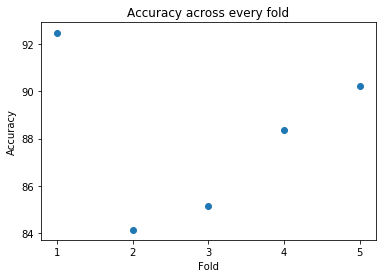

In [50]:
x = np.array([1,2,3,4,5])
plt.scatter(x, np.array(acc_per_fold))
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy across every fold')
plt.show()

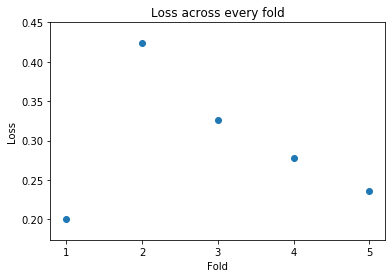

In [51]:
x = np.array([1,2,3,4,5])
plt.scatter(x, np.array(loss_per_fold))
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Loss across every fold')
plt.show()

__Result:__ The model has a decent performance in trying to detect clusters for every data point with an accuracy of almost 90%. 

__Future Work:__ This data can be combined with user specific data to build a profile for every user and appropriate recomendations can be made to serve the purpose of this project. The key takeaway is that by using BERT contextual sentence embeddings, machine learning algorithms can understand the meaning of sentences when represented in numeric format and similar movies can be grouped together by using these embeddings along with other features such as Rating and Genre.